In [2]:
import sys
import time
import warnings

#!{sys.executable} -m pip install unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pre-processing
import re
import unidecode
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
train_data1 = pd.read_csv('dataset1/X_train.csv')
train_data2 = pd.read_csv('dataset2/X_train.csv')

train_data_final = pd.concat([train_data1,train_data2], axis=0)
train_data_final.head()

,Unnamed: 0,Id,title,source URL,body,time,keywords,country,data source,language
0,446,DR-2021-000022-AFG,US Airlift Targets 70000 Afghans Displaced by ...,https://reliefweb.int/report/afghanistan/us-ai...,Herat – Afghanistan is currently facing its wo...,2018-11-20 08:00:00+00:00,"['afghans', 'displaced', 'airlift', 'iom', 'ba...",Afghanistan,news article,English
1,892,DR-2011-000121-CHN,Veteran ink artist's mountain of work on displ...,http://www.chinadaily.com.cn/cndy/2011-09/08/c...,Veteran ink artist's mountain of work on displ...,2011-09-08 07:00:00+00:00,"['display', 'xue', 'ink', 'shanshui', 'veteran...",China,news article,English
2,602,Drought Sri Lanka,Contingency fund limit increased to fight drou...,https://www.thehindu.com/news/cities/mumbai/co...,"State raises ceiling by ₹2,000 crore as Centra...",2019-02-13 08:00:00+00:00,"['immediately', 'farmers', 'state', 'contingen...",Sri Lanka,news article,English
3,128,DR-2015-000134-SOM,6 Places Destroyed By Communism Often Blamed O...,https://thelibertarianrepublic.com/6-places-de...,Ethiopia\n\nIn 1974 a Marxist-Leninist militar...,2015-10-08 07:00:00+00:00,"['blamed', 'chavez', 'destroyed', 'war', 'west...",Somalia,news article,English
4,5,DR-2014-000109-CHN,California Drought Helps Rim Fire Recovery - C...,https://www.circleofblue.org/2014/world/califo...,Little rain is not a problem for land managers...,2014-08-11 07:00:00+00:00,"['soil', 'recovery', 'large', 'drought', 'fore...",China,news article,English


In [4]:
train_data_final.shape

(268, 10)

In [5]:
train_labels1 = pd.read_csv('dataset1/y_train.csv')
train_labels2 = pd.read_csv('dataset2/y_train.csv')
train_labels = pd.concat([train_labels1,train_labels2],axis=0)
print(train_labels.shape)
train_labels.head()


(268, 2)


,Unnamed: 0,category
0,446,drought
1,892,none
2,602,drought
3,128,none
4,5,drought


In [6]:
train_data = train_data_final['title'] + ' ' + train_data_final['body']

In [7]:
train_labels['category'].value_counts()

none       138
drought    130
Name: category, dtype: int64

In [8]:
import re
from tqdm import tqdm
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(article) for article in tqdm(train_data)]

100%|██████████| 268/268 [00:00<00:00, 2512.26it/s]


In [9]:
preprocessed[0]

'us airlift targets afghans displaced by drought afghanistan reliefweb herat afghanistan is currently facing its worst drought in decades the afghanistan national disaster management authority andma and humanitarian partners have so far identified families individuals displaced in the western provinces of herat badghis and ghor between january and october of these per cent or close to individuals are children below the age of and per cent are below the age of five more than half of the displaced have settled in herat city per cent are in and around qala naw the provincial capital of badghis and the remaining two per cent in other provinces the displaced population is desperately poor and lack access to food water shelter and health services many are living in tents or in the open air with the onset of freezing winter temperatures usaid office of us foreign disaster assistance ofda is responding to the crisis with major airlift of aid including plastic sheeting blankets and kitchen sets

In [10]:
from collections import Counter
counts = dict(Counter(word for sentence in preprocessed for word in sentence.split()))
{k: counts[k] for k in list(counts)[:10]}

{'us': 147,
 'airlift': 3,
 'targets': 7,
 'afghans': 33,
 'displaced': 133,
 'by': 1045,
 'drought': 786,
 'afghanistan': 229,
 'reliefweb': 44,
 'herat': 67}

In [11]:
data_test1 = pd.read_csv('dataset1/X_test.csv')
data_test2 = pd.read_csv('dataset2/X_test.csv')

data_test_final = pd.concat([data_test1,data_test2], axis=0)

data_test = data_test_final['body'] + ' ' + data_test_final['title']
data_test = [preprocess(article) for article in tqdm(data_test)]

test_labels1 = pd.read_csv('dataset1/y_test.csv')
test_labels2 = pd.read_csv('dataset2/y_test.csv')

test_labels = pd.concat([test_labels1,test_labels2],axis=0)


100%|██████████| 132/132 [00:00<00:00, 3145.78it/s]


In [12]:
train_data_final.to_csv('train_data.csv',index=False)
train_labels.to_csv('train_labels.csv',index=False)
data_test_final.to_csv('test_data.csv',index=False)
test_labels.to_csv('test_labels.csv',index=False)

In [13]:
embed_size = 300 # how big is each word vector
max_features = 15500 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a content to use

In [14]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(preprocessed)
train_X = tokenizer.texts_to_sequences(preprocessed)
test_X = tokenizer.texts_to_sequences(data_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_labels['category'].values)
test_y = le.transform(test_labels['category'].values)
len(le.classes_)

2

In [15]:
len(tokenizer.word_index)

15604

In [16]:
import pickle
with open("tokenizer_drought_v1_2.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_drought_v1_2.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
debug = 0
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    del embeddings_index['PN']
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

if debug:
    embedding_matrix = np.random.randn(max_features,embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/Users/askani.mohankrishna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(15500, 300)

In [18]:
import numpy as np
np.save('embedding_matrix__drought_v1_2.npy' , embedding_matrix)

In [19]:
train_X1 = train_X[:2]

#Paste num in self.extra_features below 
train_X1.shape[1] - maxlen

0

In [20]:
class BiLSTM(nn.Module): 
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64
        self.extra_features = 0
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size_1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size_1*4 + self.extra_features, self.hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size_2, n_classes)

    def forward(self, x):
        input = x[:,:maxlen]
        of = x[:,maxlen:]
        
        h_embedding = self.embedding(input)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool, of), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [37]:
n_epochs = 6
batch_size = 10


model = BiLSTM()

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)#.cuda()
y_train = torch.tensor(train_y, dtype=torch.long)#.cuda()

x_cv = torch.tensor(test_X, dtype=torch.long)#.cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)#.cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    
    

<ipython-input-37-9dacf50aa5fb>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/6 	 loss=6.9267 	 val_loss=6.3039  	 val_acc=0.5985  	 time=8.28s
Epoch 2/6 	 loss=6.3788 	 val_loss=5.7680  	 val_acc=0.7121  	 time=8.30s
Epoch 3/6 	 loss=5.1548 	 val_loss=4.3491  	 val_acc=0.7803  	 time=8.28s
Epoch 4/6 	 loss=3.7632 	 val_loss=3.8235  	 val_acc=0.8182  	 time=8.22s
Epoch 5/6 	 loss=2.3771 	 val_loss=2.9714  	 val_acc=0.8561  	 time=8.24s
Epoch 6/6 	 loss=1.3718 	 val_loss=2.5010  	 val_acc=0.9167  	 time=8.17s


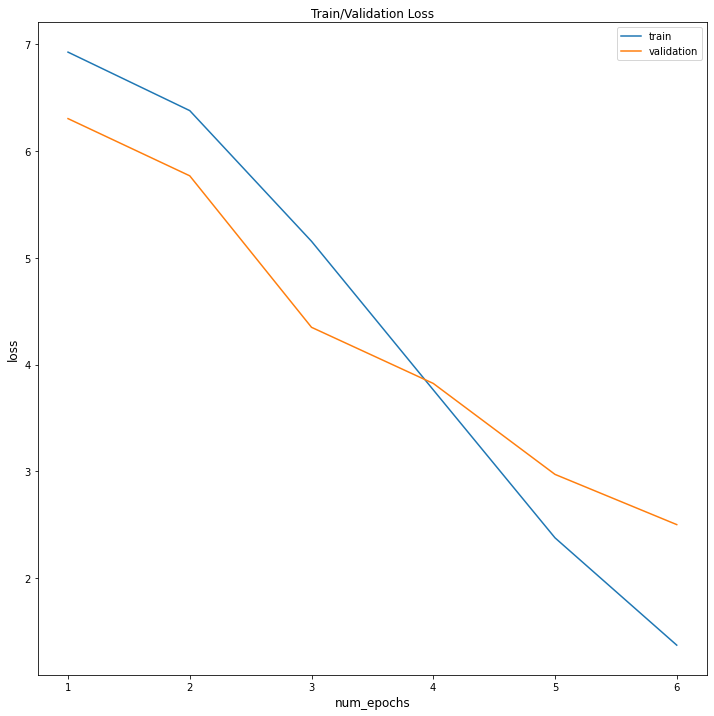

In [38]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

In [39]:
pred = le.inverse_transform(val_preds.argmax(axis=1))
test = le.inverse_transform(test_y)
from sklearn.metrics import classification_report
print(classification_report(test,pred,labels=train_labels['category'].unique()))

              precision    recall  f1-score   support

     drought       0.87      0.99      0.93        70
        none       0.98      0.84      0.90        62

    accuracy                           0.92       132
   macro avg       0.93      0.91      0.92       132
weighted avg       0.92      0.92      0.92       132



In [42]:
filename = 'model_newsclassifier_drought_v1.pt'
torch.save(model.state_dict(), filename)